In [ ]:

import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# =============================================================
# B. ĐỌC DỮ LIỆU
# =============================================================
file_path = "C:/Python code/cleaned_data_part_2_official.csv"
df = pd.read_csv(file_path)

print("✅ Dữ liệu tải thành công:", df.shape)
df.columns = df.columns.str.strip().str.replace(" ", "_")
print(df.head())

✅ Dữ liệu tải thành công: (1058, 11)
          Make       Car_Name  CC_Capacity  Horsepower  Top_Speed_kmh  \
0      FERRARI  Sf90 Stradale       3990.0       963.0          340.0   
1  ROLLS ROYCE        Phantom       6749.0       563.0          250.0   
2         FORD            Ka+       1200.0        77.5          165.0   
3     MERCEDES        Gt 63 S       3982.0       630.0          250.0   
4         AUDI     Audi R8 Gt       5204.0       602.0          320.0   

   Acceleration_0_100_sec  Price_USD  Seats  Torque_Nm Engine_Layout  \
0                     2.5  1100000.0      2      800.0        V-type   
1                     5.3   460000.0      5      900.0        V-type   
2                    10.5    13500.0      5      120.0        Inline   
3                     3.2   161000.0      4      900.0        V-type   
4                     3.6   253290.0      2      560.0        V-type   

  Fuel_Type_Cleaned  
0            Hybrid  
1            Petrol  
2            Petrol  
3  

✅ Loaded dataset: 1058 rows × 11 cols

✅ One-Hot Encoding done → 18 cols
🔁 Target Encoding for Make...
✅ Target Encoding done → added 'Make_Encoded' column
📉 Log1p applied to: ['CC_Capacity', 'Horsepower', 'Top_Speed_kmh', 'Acceleration_0_100_sec', 'Price_USD', 'Torque_Nm']
✅ Scaled 7 columns

✅ Added interaction features → total 21 columns

🧹 Dropping object columns: ['Make', 'Car_Name']
✅ Selected 18 top features for modeling

🧹 Cleaned Price_USD_log: removed 17 outliers
🧹 Cleaned Horsepower_log: removed 2 outliers
🧹 Cleaned Torque_Nm_log: removed 4 outliers
🧹 Cleaned Top_Speed_kmh_log: removed 2 outliers
🧹 Cleaned Acceleration_0_100_sec_log: removed 1 outliers

✅ After cleaning: 1032 rows remain


🚀 Training model: Linear Regression

🚀 Training model: Ridge

🚀 Training model: Lasso

🚀 Training model: Decision Tree

🚀 Training model: Random Forest

🚀 Training model: SVM

🚀 Training model: XGBoost

📊 Model Comparison:
            Model      MAE     RMSE       R2
    Random Forest 0.15

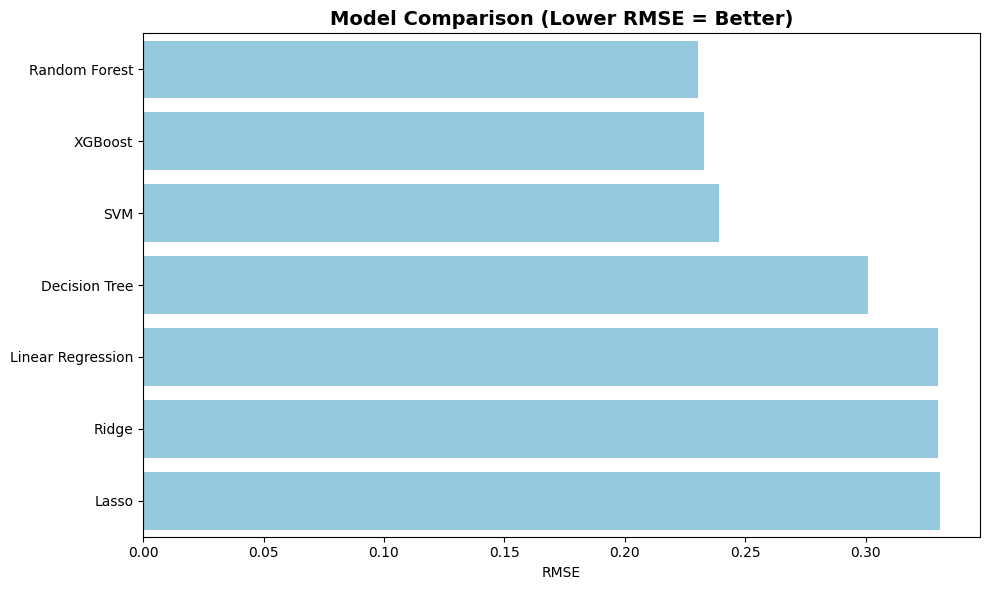


🏆 Best Model: Random Forest
   MAE = 0.16
   RMSE = 0.23
   R² = 0.9562


In [4]:

# ============================================================
# 1️⃣ LOAD DATA
# ============================================================
csv_path = "C:/Python code/cleaned_data_part_2_official.csv"  # đổi đường dẫn nếu cần
df = pd.read_csv(csv_path)
print(f"✅ Loaded dataset: {df.shape[0]} rows × {df.shape[1]} cols\n")

# ============================================================
# 2️⃣ CATEGORICAL ENCODING
# ============================================================
low_card = ['Engine_Layout', 'Fuel_Type_Cleaned']
df = pd.get_dummies(df, columns=low_card, drop_first=True)
print(f"✅ One-Hot Encoding done → {df.shape[1]} cols")

# Target Encoding cho cột Make
if 'Make' in df.columns and 'Price_USD' in df.columns:
    print("🔁 Target Encoding for Make...")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    df['Make_Encoded'] = np.nan
    for train_idx, val_idx in kf.split(df):
        train_fold = df.iloc[train_idx]
        val_fold = df.iloc[val_idx]
        mean_map = train_fold.groupby('Make')['Price_USD'].mean()
        df.loc[val_idx, 'Make_Encoded'] = val_fold['Make'].map(mean_map)
    df['Make_Encoded'].fillna(df['Price_USD'].mean(), inplace=True)
    print("✅ Target Encoding done → added 'Make_Encoded' column")

# ============================================================
# 3️⃣ NUMERICAL LOG + SCALING
# ============================================================
num_cols = ['CC_Capacity', 'Horsepower', 'Top_Speed_kmh',
            'Acceleration_0_100_sec', 'Price_USD', 'Seats', 'Torque_Nm']

skewed = df[num_cols].apply(skew, nan_policy='omit')
skewed_cols = skewed[abs(skewed) > 1].index.tolist()
print(f"📉 Log1p applied to: {skewed_cols}")

for col in skewed_cols:
    df[f"{col}_log"] = np.log1p(df[col])
df.drop(columns=skewed_cols, inplace=True)

scale_cols = [c for c in df.columns if c.endswith('_log') or c in ['Seats']]
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])
print(f"✅ Scaled {len(scale_cols)} columns\n")

# ============================================================
# 4️⃣ DATETIME FEATURES
# ============================================================
if 'Year' in df.columns:
    current_year = 2025
    df['Car_Age'] = current_year - df['Year']
    df['Is_New'] = (df['Car_Age'] <= 2).astype(int)
    print("✅ Added datetime features: Car_Age, Is_New")

# ============================================================
# 5️⃣ INTERACTION & RATIO FEATURES
# ============================================================
if 'Horsepower_log' in df.columns and 'Torque_Nm_log' in df.columns:
    df['Power_Torque_Interact'] = df['Horsepower_log'] * df['Torque_Nm_log']
if 'Top_Speed_kmh_log' in df.columns and 'Acceleration_0_100_sec_log' in df.columns:
    df['Speed_Accel_Diff'] = df['Top_Speed_kmh_log'] - df['Acceleration_0_100_sec_log']

print(f"✅ Added interaction features → total {df.shape[1]} columns\n")

# ============================================================
# 6️⃣ FEATURE SELECTION (XGBoost)
# ============================================================
target_col = 'Price_USD_log' if 'Price_USD_log' in df.columns else 'Price_USD'
y = df[target_col]
X = df.drop(columns=[target_col])

object_cols = X.select_dtypes(include=['object']).columns.tolist()
if len(object_cols) > 0:
    print(f"🧹 Dropping object columns: {object_cols}")
    X = X.drop(columns=object_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)
xgb_model.fit(X_train, y_train)

importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = importances.nlargest(30).index.tolist()
df_selected = df[top_features + [target_col]].copy()

print(f"✅ Selected {len(top_features)} top features for modeling\n")

# ============================================================
# 🧹 REMOVE OUTLIERS TO IMPROVE R²
# ============================================================

# Chọn các cột số chính cần kiểm soát outlier
outlier_cols = ['Price_USD_log', 'Horsepower_log', 'Torque_Nm_log', 
                'Top_Speed_kmh_log', 'Acceleration_0_100_sec_log']

for col in outlier_cols:
    if col in df.columns:
        mean = df[col].mean()
        std = df[col].std()
        before = df.shape[0]
        # Giữ lại các giá trị nằm trong khoảng ±3σ (3 độ lệch chuẩn)
        df = df[(df[col] > mean - 3*std) & (df[col] < mean + 3*std)]
        after = df.shape[0]
        print(f"🧹 Cleaned {col}: removed {before - after} outliers")

print(f"\n✅ After cleaning: {df.shape[0]} rows remain\n")


# ============================================================
# 7️⃣ MODEL TRAINING & EVALUATION
# ============================================================
X = df_selected.drop(columns=[target_col])
y = df_selected[target_col]

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1),
    "SVM": SVR(kernel='rbf', C=20, epsilon=0.2),
    "XGBoost": XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6,
                             subsample=0.8, colsample_bytree=0.8, random_state=42, tree_method='hist')
}

results = []
for name, model in models.items():
    print(f"\n🚀 Training model: {name}")
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("\n📊 Model Comparison:")
print(results_df.to_string(index=False))

# ============================================================
# 8️⃣ VISUALIZATION
# ============================================================
plt.figure(figsize=(10,6))
sns.barplot(x="RMSE", y="Model", data=results_df, color="skyblue")
plt.title("Model Comparison (Lower RMSE = Better)", fontsize=14, fontweight="bold")
plt.xlabel("RMSE")
plt.ylabel("")
plt.tight_layout()
plt.show()

# ============================================================
# 9️⃣ BEST MODEL
# ============================================================
best = results_df.iloc[0]
print(f"\n🏆 Best Model: {best['Model']}")
print(f"   MAE = {best['MAE']:.2f}")
print(f"   RMSE = {best['RMSE']:.2f}")
print(f"   R² = {best['R2']:.4f}")
